In [5]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [0]:
!pip install utils

In [0]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
#from utils import plot_images
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

plt.ion()   # interactive mode

In [12]:
!ls 40

train  val


In [8]:
%cd drive/My Drive/Colab_Notebooks/neuro-imaging

/content/drive/My Drive/Colab_Notebooks/neuro-imaging


In [0]:

# def get_train_valid_loader(data_dir,
#                            batch_size,
#                            augment,
#                            random_seed,
#                            valid_size=0.1,
#                            shuffle=True,
#                            show_sample=False,
#                            num_workers=4,
#                            pin_memory=False):
#     """
#     Utility function for loading and returning train and valid
#     multi-process iterators over the CIFAR-10 dataset. A sample
#     9x9 grid of the images can be optionally displayed.
#     If using CUDA, num_workers should be set to 1 and pin_memory to True.
#     Params
#     ------
#     - data_dir: path directory to the dataset.
#     - batch_size: how many samples per batch to load.
#     - augment: whether to apply the data augmentation scheme
#       mentioned in the paper. Only applied on the train split.
#     - random_seed: fix seed for reproducibility.
#     - valid_size: percentage split of the training set used for
#       the validation set. Should be a float in the range [0, 1].
#     - shuffle: whether to shuffle the train/validation indices.
#     - show_sample: plot 9x9 sample grid of the dataset.
#     - num_workers: number of subprocesses to use when loading the dataset.
#     - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
#       True if using GPU.
#     Returns
#     -------
#     - train_loader: training set iterator.
#     - valid_loader: validation set iterator.
#     """
#     error_msg = "[!] valid_size should be in the range [0, 1]."
#     assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

#     normalize = transforms.Normalize(
#         mean=[0.4914, 0.4822, 0.4465],
#         std=[0.2023, 0.1994, 0.2010],
#     )

#     # define transforms
#     valid_transform = transforms.Compose([
#             transforms.ToTensor(),
#             normalize,
#     ])
#     if augment:
#         train_transform = transforms.Compose([
#             transforms.RandomCrop(32, padding=4),
#             transforms.RandomHorizontalFlip(),
#             transforms.ToTensor(),
#             normalize,
#         ])
#     else:
#         train_transform = transforms.Compose([
#             transforms.ToTensor(),
#             normalize,
#         ])

#     # load the dataset
#     train_dataset = datasets.CIFAR10(
#         root=data_dir, train=True,
#         download=True, transform=train_transform,
#     )

#     valid_dataset = datasets.CIFAR10(
#         root=data_dir, train=True,
#         download=True, transform=valid_transform,
#     )

#     num_train = len(train_dataset)
#     indices = list(range(num_train))
#     split = int(np.floor(valid_size * num_train))

#     if shuffle:
#         np.random.seed(random_seed)
#         np.random.shuffle(indices)

#     train_idx, valid_idx = indices[split:], indices[:split]
#     train_sampler = SubsetRandomSampler(train_idx)
#     valid_sampler = SubsetRandomSampler(valid_idx)

#     train_loader = torch.utils.data.DataLoader(
#         train_dataset, batch_size=batch_size, sampler=train_sampler,
#         num_workers=num_workers, pin_memory=pin_memory,
#     )
#     valid_loader = torch.utils.data.DataLoader(
#         valid_dataset, batch_size=batch_size, sampler=valid_sampler,
#         num_workers=num_workers, pin_memory=pin_memory,
#     )

#     # visualize some images
#     if show_sample:
#         sample_loader = torch.utils.data.DataLoader(
#             train_dataset, batch_size=9, shuffle=shuffle,
#             num_workers=num_workers, pin_memory=pin_memory,
#         )
#         data_iter = iter(sample_loader)
#         images, labels = data_iter.next()
#         X = images.numpy().transpose([0, 2, 3, 1])
#         plot_images(X, labels)

#     return (train_loader, valid_loader)



In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '40'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

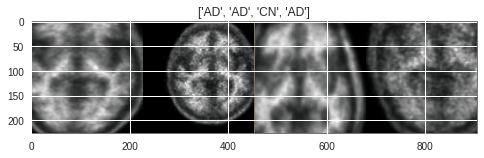

In [14]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if scheduler:
                  scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {0} / actual: {1}'.format(class_names[preds[j]], class_names[labels[i]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-5)


# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [35]:
model_ft = train_model(model_ft, criterion, optimizer_ft, scheduler=None, #exp_lr_scheduler,
                       num_epochs=25)


Epoch 0/24
----------
train Loss: 0.6825 Acc: 0.5846
val Loss: 0.5536 Acc: 0.7200

Epoch 1/24
----------
train Loss: 0.5909 Acc: 0.6875
val Loss: 0.3750 Acc: 0.9600

Epoch 2/24
----------
train Loss: 0.5251 Acc: 0.7426
val Loss: 0.2986 Acc: 0.9200

Epoch 3/24
----------
train Loss: 0.4884 Acc: 0.7757
val Loss: 0.2626 Acc: 0.8800

Epoch 4/24
----------
train Loss: 0.4633 Acc: 0.7757
val Loss: 0.3038 Acc: 0.8800

Epoch 5/24
----------
train Loss: 0.4527 Acc: 0.7831
val Loss: 0.2281 Acc: 0.9200

Epoch 6/24
----------
train Loss: 0.4520 Acc: 0.7941
val Loss: 0.2531 Acc: 0.9200

Epoch 7/24
----------
train Loss: 0.4107 Acc: 0.8088
val Loss: 0.1802 Acc: 0.8800

Epoch 8/24
----------
train Loss: 0.4359 Acc: 0.8015
val Loss: 0.2274 Acc: 0.8800

Epoch 9/24
----------
train Loss: 0.4154 Acc: 0.7904
val Loss: 0.2070 Acc: 0.9200

Epoch 10/24
----------
train Loss: 0.4164 Acc: 0.8015
val Loss: 0.2425 Acc: 0.8400

Epoch 11/24
----------
train Loss: 0.4228 Acc: 0.8272
val Loss: 0.2920 Acc: 0.8800

Ep

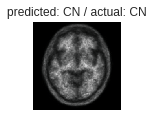

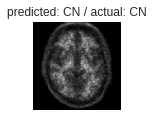

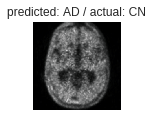

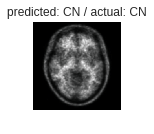

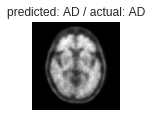

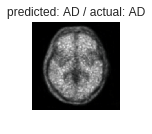

In [28]:
visualize_model(model_ft)


In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [31]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5641 Acc: 0.7316
val Loss: 0.2095 Acc: 0.9600

Epoch 1/24
----------
train Loss: 0.5745 Acc: 0.7059
val Loss: 0.2243 Acc: 1.0000

Epoch 2/24
----------
train Loss: 0.5721 Acc: 0.7059
val Loss: 0.2345 Acc: 0.9600

Epoch 3/24
----------
train Loss: 0.6056 Acc: 0.6875
val Loss: 0.2006 Acc: 1.0000

Epoch 4/24
----------
train Loss: 0.5357 Acc: 0.7500
val Loss: 0.2141 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.5705 Acc: 0.7132
val Loss: 0.2141 Acc: 0.9600

Epoch 6/24
----------
train Loss: 0.4941 Acc: 0.7574
val Loss: 0.2154 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.5884 Acc: 0.7463
val Loss: 0.2269 Acc: 0.9600

Epoch 8/24
----------
train Loss: 0.5388 Acc: 0.7353
val Loss: 0.2068 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.6012 Acc: 0.7169
val Loss: 0.2200 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.5158 Acc: 0.7426
val Loss: 0.2057 Acc: 0.9600

Epoch 11/24
----------
train Loss: 0.5466 Acc: 0.7390
val Loss: 0.2058 Acc: 1.0000

Ep

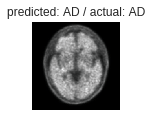

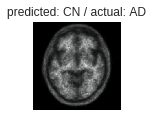

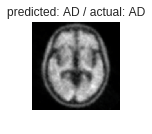

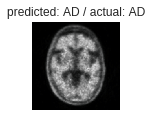

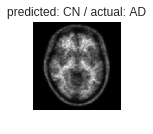

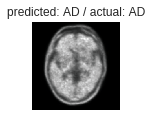

In [33]:
visualize_model(model_conv)

plt.ioff()
plt.show()